# Recurrent neural networks for H.P Lovecraft text generation

"The color out of space" is one of my favorite tales from Lovecraft, i will use it(as well as others as the call of cthulhu) to create a recurrent neural network in tensorflow that learns his style and generates new text in his style

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn) and an example from "Deep Learning Nanodegree" on udacity. Also, some information [here at r2rt](http://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html) and from [Sherjil Ozair](https://github.com/sherjilozair/char-rnn-tensorflow) on GitHub. 

## General architecture using "Long short term memory" units in the recurrent layers

<img src="assets/charseq.jpeg" width="500">

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import time
from collections import namedtuple

import numpy as np
import tensorflow as tf
from nltk.tokenize import word_tokenize
import nltk
import itertools
import matplotlib.pyplot as plt
from time import gmtime, strftime ,localtime

In [3]:
# Run only the  first time nltk is used to download language
#nltk.download()

### Define conf variables and hyper parameteters 

In [4]:
mode = "characters" #characters or words

epochs = 75
batch_size = 128       # Sequences per batch
num_steps = 300         # Number of sequence steps per batch
lstm_size = 768         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.00095 # Learning rate
keep_prob = 0.5# Dropout keep probability
negative_sampled = 1200 #in words mode ,how many negative words to sample to improve trainint time

resume_from_checkpoint = False

### Define base text
Once trained ,the network can take base text and a sequence size and generate new text using base text as first characters in the sequence. For every element in base text wi will create a list that will store generated text as training goes, to be able to compare results between steps

In [5]:
text_to_try = ["In the first place","the night before","horror","creature","night","dream","thing","That night","mountain","Ammi","Cthulhu","raven","bird","nevermore","dead","The bird"]

#### Function that separates text into tokens(for whitespace characters, only new line is implemented, missing tabs and others=

In [6]:
def tokenize_by_words(text):
    text = text.replace("\n"," new_line_token ")
    tokens = []
    splitted =[[word_tokenize(w),' ']for w in text.split()]
    splitted = list(itertools.chain(*list(itertools.chain(*splitted))))
    
    token_list = []
    i = 0
    while i < len(splitted):
        if splitted[i] == "new_line_token":
            if   token_list[-1]==" ":
                token_list[-1] = splitted[i]
            else:
                token_list.append(splitted[i])
            i+=1
        else:
            token_list.append(splitted[i])
        i+=1
    
    return token_list

def tokenize_by_characters(text):
    return list(text)

def tokenize_text(text,mode="characters"):
    if mode == "characters":
        return tokenize_by_characters(text)
    elif mode == "words":
        return tokenize_by_words(text)
    
tokenize_text("Hello, my name is Luis Leal!\n\nFrom Guatemala",mode)
#tokenize_text("Hello, my name is Luis Leal!\n\nFrom Guatemala","words")


['H',
 'e',
 'l',
 'l',
 'o',
 ',',
 ' ',
 'm',
 'y',
 ' ',
 'n',
 'a',
 'm',
 'e',
 ' ',
 'i',
 's',
 ' ',
 'L',
 'u',
 'i',
 's',
 ' ',
 'L',
 'e',
 'a',
 'l',
 '!',
 '\n',
 '\n',
 'F',
 'r',
 'o',
 'm',
 ' ',
 'G',
 'u',
 'a',
 't',
 'e',
 'm',
 'a',
 'l',
 'a']

First we'll load the text file and convert it into integers for our network to use. Here I'm creating a couple dictionaries to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [7]:
with open('corpus.txt', 'r') as f:
    text=f.read()

In [8]:
vocab = set(tokenize_text(text,mode))
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))
n_vocab = len(vocab)

### Get a little portion of text for validation

In [9]:
tokenized_text = tokenize_text(text,mode)
encoded_dataset = np.array([vocab_to_int[c] for c in tokenized_text if c in vocab_to_int], dtype=np.int32)

In [10]:
validation_size = batch_size * num_steps #create a single baty
validation_start_index = len(encoded_dataset) - validation_size

encoded = encoded_dataset[:validation_start_index]
encoded_val = encoded_dataset[validation_start_index:]

In [11]:
def encoded_to_text(encoded):
    return "".join([int_to_vocab[number] for number in encoded])

print(encoded_to_text(encoded_val[0:100]))

us memories? Had I once veritably talked with minds from reachless corners of time and space, learne


In [12]:
val_text =encoded_to_text(encoded_val)
text = encoded_to_text(encoded)

Let's check out the first 100 characters of train and validation, make sure everything is peachy.  line of a book ever.

In [13]:
text[:100]

'THE COLOUR OUT OF SPACE\n\nWest of Arkham the hills rise wild, and there are valleys with deep woods t'

In [14]:
val_text[:100]

'us memories? Had I once veritably talked with minds from reachless corners of time and space, learne'

And we can see the characters encoded as integersin both train and validation

In [15]:
encoded[:100]

array([101,  39,  96,  76,  83,  60,  53,  60, 102,   6,  76,  60, 102,
       101,  76,  60,  18,  76,  34,  86,   2,  83,  96,  55,  55,  33,
        48,  35,  10,  76,  31,  24,  76,   2,  50, 103,  21,  80,  28,
        76,  10,  21,  48,  76,  21,  37,  56,  56,  35,  76,  50,  37,
        35,  48,  76,  52,  37,  56,  29,  68,  76,  80,  91,  29,  76,
        10,  21,  48,  50,  48,  76,  80,  50,  48,  76,  74,  80,  56,
        56,  48,  12,  35,  76,  52,  37,  10,  21,  76,  29,  48,  48,
        78,  76,  52,  31,  31,  29,  35,  76,  10], dtype=int32)

In [16]:
encoded_val[0:100]

array([  3,  35,  76,  28,  48,  28,  31,  50,  37,  48,  35,  40,  76,
        39,  80,  29,  76,  20,  76,  31,  91,  62,  48,  76,  74,  48,
        50,  37,  10,  80,  70,  56,  12,  76,  10,  80,  56, 103,  48,
        29,  76,  52,  37,  10,  21,  76,  28,  37,  91,  29,  35,  76,
        24,  50,  31,  28,  76,  50,  48,  80,  62,  21,  56,  48,  35,
        35,  76,  62,  31,  50,  91,  48,  50,  35,  76,  31,  24,  76,
        10,  37,  28,  48,  76,  80,  91,  29,  76,  35,  78,  80,  62,
        48,  68,  76,  56,  48,  80,  50,  91,  48], dtype=int32)

Since the network is working with individual english tokens, it's similar to a classification problem in which we are trying to predict the next character from the previous text.  Here's how many 'classes' our network has to pick from.

In [17]:
len(vocab)

104

## Making training mini-batches

Here is where we'll make our mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


<br>
We have our text encoded as integers as one long array in `encoded`. Let's create a function that will give us an iterator for our batches. I like using [generator functions](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) to do this. Then we can pass `encoded` into this function and get our batch generator.

The first thing we need to do is discard some of the text so we only have completely full batches. Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences) and $M$ is the number of steps. Then, to get the number of batches we can make from some array `arr`, you divide the length of `arr` by the batch size. Once you know the number of batches and the batch size, you can get the total number of characters to keep.

After that, we need to split `arr` into $N$ sequences. You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences (`n_seqs` below), let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$ where $K$ is the number of batches.

Now that we have this array, we can iterate through it to get our batches. The idea is each batch is a $N \times M$ window on the array. For each subsequent batch, the window moves over by `n_steps`. We also want to create both the input and target arrays. Remember that the targets are the inputs shifted over one character. You'll usually see the first input character used as the last target character, so something like this:
```python
y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
```
where `x` is the input batch and `y` is the target batch.

The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of steps in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `n_steps` wide.

In [18]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the batch size and number of batches we can make
    batch_size = n_seqs * n_steps 
    n_batches =  len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr =  arr[:n_batches*batch_size]
    
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs,-1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:,n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros(x.shape)
        y[:,:-1],y[:,-1] = x[:,1:] ,x[:,0]
        yield x, y

Now I'll make my data sets and we can check out what's going on here. Here I'm going to use a batch size of 10 and 50 sequence steps.

In [19]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)

In [20]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[101  39  96  76  83  60  53  60 102   6]
 [ 31  35  48  76  48  91  29  76  52  80]
 [ 37  91  76  28  12  76  37  91  10  48]
 [ 76  91  31  10  76  35  48  48  76  10]
 [ 35  76  10  31  76  70  48  76  29  48]
 [ 10  48  50  50  37  24  37  62  76  56]
 [ 48  62  31  28  37  91  36  76  31  24]
 [ 76  21  31  52  76  36  56  80  29  76]
 [ 74  80  56  76  29  50  48  52  76  91]
 [ 24  48  50  48  50  93  35  76  35  10]]

y
 [[  39.   96.   76.   83.   60.   53.   60.  102.    6.   76.]
 [  35.   48.   76.   48.   91.   29.   76.   52.   80.   35.]
 [  91.   76.   28.   12.   76.   37.   91.   10.   48.   91.]
 [  91.   31.   10.   76.   35.   48.   48.   76.   10.   21.]
 [  76.   10.   31.   76.   70.   48.   76.   29.   48.   50.]
 [  48.   50.   50.   37.   24.   37.   62.   76.   56.   31.]
 [  62.   31.   28.   37.   91.   36.   76.   31.   24.   76.]
 [  21.   31.   52.   76.   36.   56.   80.   29.   76.   20.]
 [  80.   56.   76.   29.   50.   48.   52.   76.   91.   

## Building the model

Below is where you'll build the network. We'll break it up into parts so it's easier to reason about each bit. Then we can connect them up into the whole network.

<img src="assets/charRNN.png" width=500px>


### Inputs

First off we'll create our input placeholders. As usual we need placeholders for the training data and the targets. We'll also create a placeholder for dropout layers called `keep_prob`. This will be a scalar, that is a 0-D tensor. To make a scalar, you create a placeholder without giving it a size.

In [21]:
def build_inputs(batch_size, num_steps):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(tf.int32,[batch_size,num_steps],name="inputs")
    targets = tf.placeholder(tf.int32,[batch_size,num_steps],name="targets")
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32,name="keep_prob")
    
    return inputs, targets, keep_prob

### LSTM Cell

Here we will create the LSTM cell we'll use in the hidden layer. We'll use this cell as a building block for the RNN. So we aren't actually defining the RNN here, just the type of cell we'll use in the hidden layer.

We first create a basic LSTM cell with

```python
lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
```

where `num_units` is the number of units in the hidden layers in the cell. Then we can add dropout by wrapping it with 

```python
tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
```
You pass in a cell and it will automatically add dropout to the inputs or outputs. Finally, we can stack up the LSTM cells into layers with [`tf.contrib.rnn.MultiRNNCell`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/MultiRNNCell). With this, you pass in a list of cells and it will send the output of one cell into the next cell. For example,

```python
tf.contrib.rnn.MultiRNNCell([cell]*num_layers)
```

This might look a little weird if you know Python well because this will create a list of the same `cell` object. However, TensorFlow will create different weight matrices for all `cell` objects. Even though this is actually multiple LSTM cells stacked on each other, you can treat the multiple layers as one cell.

We also need to create an initial cell state of all zeros. This can be done like so

```python
initial_state = cell.zero_state(batch_size, tf.float32)
```


In [22]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
        lstm_size: Size of the hidden layers in the LSTM cells
        num_layers: Number of LSTM layers
        batch_size: Batch size

    '''
    ### Build the LSTM Cell
    # Use a basic LSTM cell
    # Add dropout to the cell outputs
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper( tf.contrib.rnn.BasicLSTMCell(lstm_size),output_keep_prob = keep_prob) for _ in range(num_layers)])
    initial_state = cell.zero_state(batch_size,tf.float32)
    
    return cell, initial_state

### RNN Output

Here we'll create the output layer. We need to connect the output of the RNN cells to a full connected layer with a softmax output. The softmax output gives us a probability distribution we can use to predict the next character, so we want this layer to have size $C$, the number of classes/characters we have in our text.

If our input has batch size $N$, number of steps $M$, and the hidden layer has $L$ hidden units, then the output is a 3D tensor with size $N \times M \times L$. The output of each LSTM cell has size $L$, we have $M$ of them, one for each sequence step, and we have $N$ sequences. So the total size is $N \times M \times L$. 

We are using the same fully connected layer, the same weights, for each of the outputs. Then, to make things easier, we should reshape the outputs into a 2D tensor with shape $(M * N) \times L$. That is, one row for each sequence and step, where the values of each row are the output from the LSTM cells. We get the LSTM output as a list, `lstm_output`. First we need to concatenate this whole list into one array with [`tf.concat`](https://www.tensorflow.org/api_docs/python/tf/concat). Then, reshape it (with `tf.reshape`) to size $(M * N) \times L$.

One we have the outputs reshaped, we can do the matrix multiplication with the weights. We need to wrap the weight and bias variables in a variable scope with `tf.variable_scope(scope_name)` because there are weights being created in the LSTM cells. TensorFlow will throw an error if the weights created here have the same names as the weights created in the LSTM cells, which they will be default. To avoid this, we wrap the variables in a variable scope so we can give them unique names.


In [23]:
def build_output(lstm_output, in_size, out_size):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        lstm_output: List of output tensors from the LSTM layer
        in_size: Size of the input tensor, for example, size of the LSTM cells
        out_size: Size of this softmax layer
    
    '''
    print(lstm_output)
    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # Concatenate lstm_output over axis 1 (the columns)
    seq_output = tf.concat(lstm_output,axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    x = tf.reshape(seq_output,[-1,in_size])
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal((in_size, out_size),stddev=0.1))
        softmax_b = tf.Variable(tf.zeros([out_size]))
    
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits =  tf.add(tf.matmul(x,softmax_w),softmax_b) 
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits,name ="out")
    
    return out, logits,softmax_w,softmax_b,x

### Training loss

Next up is the training loss. We get the logits and targets and calculate the softmax cross-entropy loss. First we need to one-hot encode the targets, we're getting them as encoded characters. Then, reshape the one-hot targets so it's a 2D tensor with size $(M*N) \times C$ where $C$ is the number of classes/characters we have. Remember that we reshaped the LSTM outputs and ran them through a fully connected layer with $C$ units. So our logits will also have size $(M*N) \times C$.

Then we run the logits and targets through `tf.nn.softmax_cross_entropy_with_logits` and find the mean to get the loss.

In [24]:
def build_loss(lstm_output,logits, targets, lstm_size, num_classes,softmax_w,softmax_b):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
        logits: Logits from final fully connected layer
        targets: Targets for supervised learning
        lstm_size: Number of LSTM hidden units
        num_classes: Number of classes in targets
        
    '''
    # One-hot encode targets and reshape to match logits, one row per sequence per step
    y_one_hot = tf.one_hot(targets,num_classes)
    y_reshaped =  tf.reshape(y_one_hot,logits.get_shape())
    
    
    # Softmax cross entropy loss
    if mode == "characters":
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_reshaped))
    elif mode == "words":
        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(tf.transpose(softmax_w),softmax_b,tf.reshape(tf.argmax( y_reshaped,axis = 1),shape=(y_reshaped.get_shape()[0],1)),tf.concat(lstm_output,axis=1),negative_sampled,len(vocab)))
    
    return loss

### Optimizer

Here we build the optimizer. Normal RNNs have have issues gradients exploding and disappearing. LSTMs fix the disappearance problem, but the gradients can still grow without bound. To fix this, we can clip the gradients above some threshold. That is, if a gradient is larger than that threshold, we set it to the threshold. This will ensure the gradients never grow overly large. Then we use an AdamOptimizer for the learning step.

In [25]:
def build_optimizer(loss, learning_rate, grad_clip,global_step):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
        global_step: to control the total number of train steps
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars),global_step)
    
    return optimizer

### Build the network

Now we can put all the pieces together and build a class for the network. To actually run data through the LSTM cells, we will use [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/nn/dynamic_rnn). This function will pass the hidden and cell states across LSTM cells appropriately for us. It returns the outputs for each LSTM cell at each step for each sequence in the mini-batch. It also gives us the final LSTM state. We want to save this state as `final_state` so we can pass it to the first LSTM cell in the the next mini-batch run. For `tf.nn.dynamic_rnn`, we pass in the cell and initial state we get from `build_lstm`, as well as our input sequences. Also, we need to one-hot encode the inputs before going into the RNN. 


In [26]:
class CharRNN:
    
    def __init__(self, num_classes, batch_size=64, num_steps=50, 
                       lstm_size=128, num_layers=2, learning_rate=0.001, 
                       grad_clip=5, sampling=False):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        self.global_step_tensor = tf.Variable(0,trainable=False,name = "global_step")
        # Build the input placeholder tensors
        self.inputs, self.targets, self.keep_prob = build_inputs(batch_size,num_steps)
        # Build the LSTM cell
        cell, self.initial_state = build_lstm(lstm_size,num_layers,batch_size,self.keep_prob)
        ### Run the data through the RNN layers
        # First, one-hot encode the input tokens
        x_one_hot = tf.one_hot(self.inputs,num_classes)
        
        self.grad_clip  = grad_clip
        # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
        outputs, state = tf.nn.dynamic_rnn(cell,x_one_hot,initial_state=self.initial_state)
        self.final_state = state
        
        # Get softmax predictions and logits
        self.prediction, self.logits ,self.softmax_w,self.softmax_b,self.lstm_output_reshaped  = build_output(outputs,lstm_size,num_classes)
        
        # Loss and optimizer (with gradient clipping)
        self.loss =  build_loss(self.lstm_output_reshaped ,self.logits,self.targets,lstm_size,num_classes,self.softmax_w,self.softmax_b)
        self.optimizer = build_optimizer(self.loss,learning_rate,grad_clip,self.global_step_tensor)

## Hyperparameters

Here are the hyperparameters for the network.

* `batch_size` - Number of sequences running through the network in one pass.
* `num_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lstm_size` - The number of units in the hidden layers.
* `num_layers` - Number of hidden LSTM layers to use
* `learning_rate` - Learning rate for training
* `keep_prob` - The dropout keep probability when training. If you're network is overfitting, try decreasing this.

Here's some good advice from Andrej Karpathy on training the network:. 

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `lstm_size` and `num_layers`. I would advise that you always use `num_layers` of either 2/3. The `lstm_size` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `lstm_size` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

In [27]:
def get_number_of_parameters():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        #print(shape)
        #print(len(shape))
        variable_parameters = 1
        
        for dim in shape:
            #print(dim)
            variable_parameters*=dim.value
        #print(variable_parameters)
        total_parameters+= variable_parameters
    return total_parameters

In [28]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. Here we also get back the final LSTM state for the mini-batch. Then, we pass that state back into the network so the next batch can continue the state from the previous batch. And every so often (set by `save_every_n`) I save a checkpoint.

Here I'm saving checkpoints with the format

`i{iteration number}_l{# hidden layer units}.ckpt`


In [29]:
losses = {"train":[],"validation":[]}
x_steps = list()

In [30]:
#epochs = 1
# Save every N iterations
save_every_n = 500
print_loss_every_n = 25
sample_every = 500
print_epoch_time_every = 10

with tf.device("/gpu:0"):
    model = CharRNN(len(vocab), batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)
    #print("after model")

saver = tf.train.Saver(max_to_keep=5)
print("Training starting at time:",strftime("%Y-%m-%d %H:%M:%S", localtime()))
train_start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Number of parameters:",get_number_of_parameters(),"Dataset size:",len(encoded))
    #print("after initializer")
    if resume_from_checkpoint:
        latest_checkpoint = tf.train.latest_checkpoint('checkpoints')
        saver.restore(sess, latest_checkpoint)
    counter = 0
    for e in range(epochs):
        # Train network
        epoch_start = time.time()
        
        new_state = sess.run(model.initial_state)
        loss = 0
        for x, y in get_batches(encoded, batch_size, num_steps):
            
            
            start = time.time()
            feed = {model.inputs: x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                 model.final_state, 
                                                 model.optimizer], 
                                                 feed_dict=feed)
        
            
            end = time.time()
            if counter%print_loss_every_n == 0:
                val_batches = get_batches(encoded_val,int(len(encoded_val)/num_steps),num_steps)
                x_val,y_val = next(val_batches)
                
                val_dict = {model.inputs: x_val,
                            model.targets: y_val,
                            model.keep_prob: 1,
                            model.initial_state: new_state}
                
                val_loss,prediction = sess.run([model.loss,model.prediction],feed_dict=val_dict)
                
                losses["train"].append(batch_loss)
                losses["validation"].append(val_loss)
                
                
                global_step = tf.train.global_step(sess,model.global_step_tensor)
                x_steps.append(global_step)
                
                print('Epoch: {}/{}... '.format(e+1, epochs),
                      'Training Step: {}... '.format(global_step),
                      'Training loss: {:.4f}... '.format(batch_loss),
                      'Val loss: {:.4f}... '.format(val_loss),
                      '{:.4f} sec/batch'.format((end-start)))
        
            if (counter % save_every_n == 0):
                global_step = tf.train.global_step(sess,model.global_step_tensor)
                saver.save(sess, "checkpoints/m{}_i{}_l{}.ckpt".format(mode,global_step, lstm_size))
                
            counter += 1
            #learning_rate*=0.75
            #model.optimizer = build_optimizer(model.loss,learning_rate,model.grad_clip,model.global_step_tensor)
        
        epoch_end = time.time()
        
        
        if ((e+1) % print_epoch_time_every== 0):
            print('Epoch {}/{} time:{}...'.format(e+1,epochs,epoch_end-epoch_start),
                 " finished at",strftime("%Y-%m-%d %H:%M:%S", localtime()))
        
            
    global_step = tf.train.global_step(sess,model.global_step_tensor)
    saver.save(sess, "checkpoints/m{}_i{}_l{}.ckpt".format(mode,global_step, lstm_size))
    
print("Training ending at time:",strftime("%Y-%m-%d %H:%M:%S", localtime()))
print("Trainint total time:",time.time()-train_start_time)

Tensor("rnn/transpose:0", shape=(128, 300, 768), dtype=float32)
Training starting at time: 2017-11-02 09:27:54
Number of parameters: 7483496 Dataset size: 3175095
Epoch: 1/75...  Training Step: 1...  Training loss: 4.6445...  Val loss: 4.4777...  1.3072 sec/batch
Epoch: 1/75...  Training Step: 26...  Training loss: 3.1276...  Val loss: 3.0785...  1.0762 sec/batch
Epoch: 1/75...  Training Step: 51...  Training loss: 3.0537...  Val loss: 3.0496...  1.0698 sec/batch
Epoch: 1/75...  Training Step: 76...  Training loss: 3.0283...  Val loss: 3.0103...  1.0709 sec/batch
Epoch: 2/75...  Training Step: 101...  Training loss: 2.8958...  Val loss: 2.8967...  1.0717 sec/batch
Epoch: 2/75...  Training Step: 126...  Training loss: 2.7121...  Val loss: 2.7372...  1.0702 sec/batch
Epoch: 2/75...  Training Step: 151...  Training loss: 2.5499...  Val loss: 2.5146...  1.0719 sec/batch
Epoch: 3/75...  Training Step: 176...  Training loss: 2.4718...  Val loss: 2.4097...  1.0717 sec/batch
Epoch: 3/75...  Tr

Epoch: 24/75...  Training Step: 1901...  Training loss: 1.3513...  Val loss: 1.3684...  1.0720 sec/batch
Epoch: 24/75...  Training Step: 1926...  Training loss: 1.3422...  Val loss: 1.3646...  1.0731 sec/batch
Epoch: 24/75...  Training Step: 1951...  Training loss: 1.3305...  Val loss: 1.3669...  1.0722 sec/batch
Epoch: 25/75...  Training Step: 1976...  Training loss: 1.3131...  Val loss: 1.3650...  1.0723 sec/batch
Epoch: 25/75...  Training Step: 2001...  Training loss: 1.2948...  Val loss: 1.3617...  1.0716 sec/batch
Epoch: 25/75...  Training Step: 2026...  Training loss: 1.3102...  Val loss: 1.3592...  1.0728 sec/batch
Epoch: 26/75...  Training Step: 2051...  Training loss: 1.3340...  Val loss: 1.3610...  1.0716 sec/batch
Epoch: 26/75...  Training Step: 2076...  Training loss: 1.3012...  Val loss: 1.3555...  1.0712 sec/batch
Epoch: 26/75...  Training Step: 2101...  Training loss: 1.3127...  Val loss: 1.3501...  1.0724 sec/batch
Epoch: 26/75...  Training Step: 2126...  Training loss:

Epoch: 47/75...  Training Step: 3826...  Training loss: 1.1455...  Val loss: 1.3588...  1.0725 sec/batch
Epoch: 47/75...  Training Step: 3851...  Training loss: 1.1642...  Val loss: 1.3674...  1.0743 sec/batch
Epoch: 48/75...  Training Step: 3876...  Training loss: 1.1504...  Val loss: 1.3654...  1.0724 sec/batch
Epoch: 48/75...  Training Step: 3901...  Training loss: 1.1550...  Val loss: 1.3597...  1.0726 sec/batch
Epoch: 48/75...  Training Step: 3926...  Training loss: 1.1420...  Val loss: 1.3658...  1.0741 sec/batch
Epoch: 49/75...  Training Step: 3951...  Training loss: 1.1494...  Val loss: 1.3751...  1.0733 sec/batch
Epoch: 49/75...  Training Step: 3976...  Training loss: 1.1461...  Val loss: 1.3687...  1.0728 sec/batch
Epoch: 49/75...  Training Step: 4001...  Training loss: 1.1367...  Val loss: 1.3716...  1.0738 sec/batch
Epoch: 50/75...  Training Step: 4026...  Training loss: 1.1205...  Val loss: 1.3711...  1.0727 sec/batch
Epoch: 50/75...  Training Step: 4051...  Training loss:

Epoch 70/75 time:88.84116983413696...  finished at 2017-11-02 11:11:46
Epoch: 71/75...  Training Step: 5751...  Training loss: 1.0529...  Val loss: 1.4269...  1.0720 sec/batch
Epoch: 71/75...  Training Step: 5776...  Training loss: 1.0325...  Val loss: 1.4367...  1.0757 sec/batch
Epoch: 71/75...  Training Step: 5801...  Training loss: 1.0417...  Val loss: 1.4341...  1.0723 sec/batch
Epoch: 72/75...  Training Step: 5826...  Training loss: 1.0533...  Val loss: 1.4398...  1.0727 sec/batch
Epoch: 72/75...  Training Step: 5851...  Training loss: 1.0484...  Val loss: 1.4329...  1.0722 sec/batch
Epoch: 72/75...  Training Step: 5876...  Training loss: 1.0383...  Val loss: 1.4317...  1.0733 sec/batch
Epoch: 72/75...  Training Step: 5901...  Training loss: 1.0595...  Val loss: 1.4410...  1.0733 sec/batch
Epoch: 73/75...  Training Step: 5926...  Training loss: 1.0364...  Val loss: 1.4454...  1.0722 sec/batch
Epoch: 73/75...  Training Step: 5951...  Training loss: 1.0544...  Val loss: 1.4342...  1

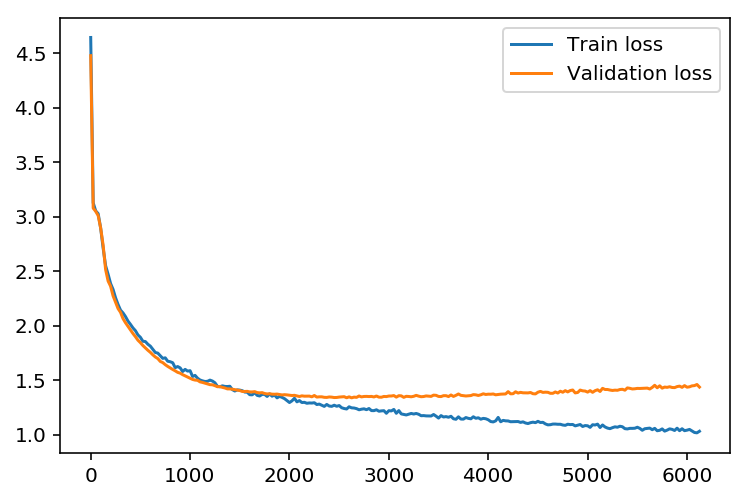

In [31]:
plt.plot(x_steps,losses["train"],label="Train loss")
plt.plot(x_steps,losses["validation"],label="Validation loss")
plt.legend()
_ = plt.ylim()

#### Saved checkpoints

Read up on saving and loading checkpoints here: https://www.tensorflow.org/programmers_guide/variables

In [32]:
checkpoints = tf.train.get_checkpoint_state('checkpoints')

## Sampling final trained model

Now that the network is trained, we'll can use it to generate new text. The idea is that we pass in a character, then the network will predict the next character. We can use the new one, to predict the next one. And we keep doing this to generate all new text. I also included some functionality to prime the network with some text by passing in a string and building up a state from that.

The network gives us predictions for each character. To reduce noise and make things a little less random, I'm going to only choose a new character from the top N most likely characters.



In [33]:
def sample(checkpoint, n_samples, lstm_size, vocab_size, prime="The ",mode="characters"):
    print(mode)
    samples = tokenize_text(prime,mode)
    model = CharRNN(len(vocab), lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for c in tokenize_text(prime,mode):
            x = np.zeros((1, 1))
            x[0,0] = vocab_to_int[c]
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

        c = pick_top_n(preds, len(vocab))
        samples.append(int_to_vocab[c])

        for i in range(n_samples):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, len(vocab))
            samples.append(int_to_vocab[c])
        
    return ''.join(samples).replace("new_line_token","\n")

Here, pass in the path to a checkpoint and sample from the network.

In [34]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints/mcharacters_i6150_l768.ckpt'

## Generate new text from "base" text

In [35]:

checkpoint = tf.train.latest_checkpoint('checkpoints')


samples = list()
for text in text_to_try:
    #print("------------------------",text)
    samples.append( sample(checkpoint, 500, lstm_size, len(vocab), prime=text,mode=mode))
    #print(samp)
    #print("------------------------")

characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensor

In [36]:
for i in range(len(text_to_try)):
    text = text_to_try[i]
    generated = samples[i]
    print("------------------------",text)
    print(generated)
    print("------------------------")

------------------------ In the first place
In the first place where the brute seemed to town and strange the long, bottomless day.

All the mad pensalion of the day on the street, the doctor had seen a sound of delicate speech of carry and curring remaining peculiar sense of transition and soon became terrible from the old case where its conversation was constantly straightened. We were not to be found on a service of cold class on some person or strange sheps. He was a chance with all the most immense columns. Over the chamber stone had been still touched
------------------------
------------------------ the night before
the night before we could not be so far as possible. We saw that the first we shall never spoke to the front side of a second which was not for such things. A man shot in stupe for the stone, as we strowed in their brain and depth to one of the singular carvings and shipping windows of the strange spring well. It is obvious that the others would have been able to dis

In [37]:
tf.train.get_checkpoint_state('checkpoints')

model_checkpoint_path: "checkpoints/mcharacters_i6150_l768.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i4501_l768.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i5001_l768.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i5501_l768.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i6001_l768.ckpt"
all_model_checkpoint_paths: "checkpoints/mcharacters_i6150_l768.ckpt"

In [38]:
generated = sample(checkpoint, 5000, lstm_size, len(vocab), prime="The old folk have gone away",mode=mode)
print(generated)

characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
The old folk have gone away then the fragment, still transperious arms once much as is of the second stone to the body as they have not seen their story and made me to take away from them. Their member had sent the stone problem—a door-stopy and tittering, wide ram and part which, or then attach to the stone side. Only its possession had seen the sea, and one of the people will never forget all their curiosity to his studies. Though the creature was a pendulum which howed the familiar town as the fact is of the most surprising sound wherein indeed was the stormet thing behind the shouted regular tradition—one of these waves of an army and commander of string substance, because of the folklore they had struck some of the murderers and a crude fresh subject to a day or one in all other parts, and they all hidden takes through which someh

In [39]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="The thing that should not be",mode=mode)
print(generated)

characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
The thing that should not be able to reach him and disappointed the cross succession of tendency a moring alien-subtargeness. In this was the distinct flood of the church traced on the single glening wood and turned in a somewhat plot for the sound. It was the consciousness of the complex angles of the ship on the corner of the heart and a solid passage of the camp to what it might be conceived, and after that sound of courtear-hair seemed an evidently sense of muddier, so that he was surprisingly abandoned. The conterts was an ununderstanding of the hospital, with a proper part of the shantak-body at the beginning of our present disposal. I went to my extraordinary path, I said who should have sought to be much like that. And now there is no many sound the short wounded which I had across the sea. I felt in me a minute interest in the

In [40]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="THE THING THAT LURKS IN GUATEMALA CITY\n\n",mode=mode)
print(generated)

characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
THE THING THAT LURKS IN GUATEMALA CITY

Abover Sim, Erid, And Math Broth, Sal.m. Too, the station around us set himself off off at least from our coming of Saltossail, and were in the distance from the set of the old Cornighan powter. It had come a seven chamber of studies which would probably have been already in his possession. What had seen a short child had so far transferred the scene into accuracy of these ancient winders, and with which it is a subtle terrible or exercise there would be no madmen of him to stealiey, and was never alive as to be on some dream of my possession; and the second of the steps were simply the same. While there was something which had been seen solid and deserted, black, waterful, and disturbing in a little dream the crypt of a solid profound animal. At last the gloom was not already for the former age 

In [41]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="THE NIGHTMARE IN GUATEMALA CITY\n\n",mode=mode)
print(generated)

characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
THE NIGHTMARE IN GUATEMALA CITY

Of Marie's distinct and notice."

   "It was a simultaneous passage in Paris. With it the cargo of madness -- wook from my chamber, the chances of a parasol, objective countenance; this is in some cause of death?" 

"The course --the path of the steam overhand off the changeless district. It is terror as it can still a present discovery although, it is not to be to do to see that she was a present of the senses of a fresh infinite and somewhat sinister stranger as of such as is the perceiving that of the portrait or experiment. The most imagination of more there is more than simultaneous fountains, the crowd in sound; so that the most present is that of the mind of the summit of the head; their own person is the limits to tell what was intoxer, is impossible to conceal. Wish you will be discovered, that

In [42]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="ONCE UPON A CREEPY NIGHT\n\nAll saints eve magic was mysterious",mode=mode)
print(generated)

characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
ONCE UPON A CREEPY NIGHT

All saints eve magic was mysterious. It was no less insidure that the serious carvings were closed and partly into a faithful strick fragment and probably to the strange case which would have concluded our chance to account for the modern strange, as well as the study of the Curwen dammage was not to be disputed. He continued to compare his stone proposaly in his pattern to the certain other antiquarian and held officials of the previous course in the crowd. That there was a sub-like strangel toward his shoulder, with a counteyach still falling into the stormen. The true conversation were the seven or two man who had still searched the heavy shantak, and the crew would be so few and so find them. With their metal through the floor were not for the present, however, when he collected the condition of human madn

In [43]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="I have never been so afraid in my life. The trembling of the legs is uncontrollable. I do not think I survive tonight...",mode=mode)
print(generated)

characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
I have never been so afraid in my life. The trembling of the legs is uncontrollable. I do not think I survive tonight...The why had it is. He had the point of this mark of madness on the floor. The whole person in the short bridge, so that the menace had never forgot heard from the police, titan old Mailest Lond, and the father that the streets and shrabitioss of the stories was in the muddy. The foot which threw his friend in a cloud which had so long age at a great singular condition, all sentinely to say that it had concerned them off into the anxiety as an extremely plain. When we were new folder of trouble, he had to talk with a start or frightful country, and those who saw that a series of story hall chiefly had been seen out of him. There were no letters in the more speed of the bottom, a somboth cut of free, and a countenance o

In [44]:
generated = sample(checkpoint, 50000, lstm_size, len(vocab), prime="THE THING THAT SHOULD NOT BE\n\n",mode=mode)
print(generated)

characters
Tensor("rnn/transpose:0", shape=(1, 1, 768), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/mcharacters_i6150_l768.ckpt
THE THING THAT SHOULD NOT BE

And the chamber door I have hoped that the sheller openation has seen the last forest of the heavy.
     “What is, he seemed as said—one ment of your fears. . . .”
     West’s shadow had to three sides of the building which shook through the short chanted in the heelless place, the gravesoned horizon was shouting, wharves at a memory of some height. The shrieking of the great garden stick and trappords of the house was not from the books, and one of the men was an insufferable description of his discussion. Wish to speak of the present character, the claw-print of the stone shelter of the ship for a second at hallow which stood in his forefarther. He could see any place as seen beyond the desert which had come for a face in the crawling chaos of the men. When the stranger had been a marvellous shadow, the 